# RNA segmentation

In this tutorial, we will assume we only have the RNA image available without any staining and attempt to use the RNA signal to identify single cells.

<div class="alert alert-info">

See also

[RNA segmentation](../../technicals/cell_segmentation.md#rna-segmentation)

</div>

This is done in the following steps.

1. Identify nuclei using nuclear-localized genes (in our case, we'll use the `Malat1` and `Neat1` genes).
2. Identify additional nuclei using unspliced RNA.
3. [Optional] Expand the nuclei labels to cytoplasm.

In [59]:
import sys
sys.path.insert(0,"/home/panhailin/software/source/git_hub/spateo-release/")
import spateo as st
import matplotlib.pyplot as plt

st.config.n_threads = 8
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

## Load the data

We will be using a truncated mouse coronal section dataset from [Chen et al., 2021](https://doi.org/10.1101/2021.01.17.427004).

In [36]:
!wget "https://drive.google.com/uc?export=download&id=18sM-5LmxOgt-3kq4ljtq_EdWHjihvPUx" -nc -O SS200000135TL_D1_all_bin1.txt.gz

文件 ‘SS200000135TL_D1_all_bin1.txt.gz’ 已存在；不获取。


Load the downloaded UMI counts and nuclei staining image into an AnnData object. For the purposes of cell segmentation, we will be working with an aggregated counts matrix, where the `obs` and `var` of the AnnData correspond to the spatial X and Y coordinates, and each element of the matrix contains the total number of UMIs captured for each X and Y coordinate.

<div class="alert alert-info">
Note
    
We will be using the `Malat1` gene and unspliced RNA to identify nuclei. We are providing the `gene_agg` argument so that the resulting AnnData will have a layer containing combined `Malat1` and `Neat1` counts.
    
</div>

In [2]:
adata = st.io.read_bgi_agg(
    'SS200000135TL_D1_all_bin1.txt.gz',
    gene_agg={'nuclear': ['Malat1', 'Neat1']}  # Add a layer for nuclear-localized genes
)
adata

|-----> Constructing count matrices.
|-----> Aggregating counts for genes provided by `gene_agg`.
|-----> <insert> __type to uns in AnnData Object.
|-----> <insert> pp to uns in AnnData Object.
|-----> <insert> spatial to uns in AnnData Object.


AnnData object with n_obs × n_vars = 2000 × 2000
    uns: '__type', 'pp', 'spatial'
    layers: 'spliced', 'unspliced', 'nuclear'

|-----> <select> nuclear layer in AnnData Object
|-----> <select> unspliced layer in AnnData Object
|-----> <select> X layer in AnnData Object


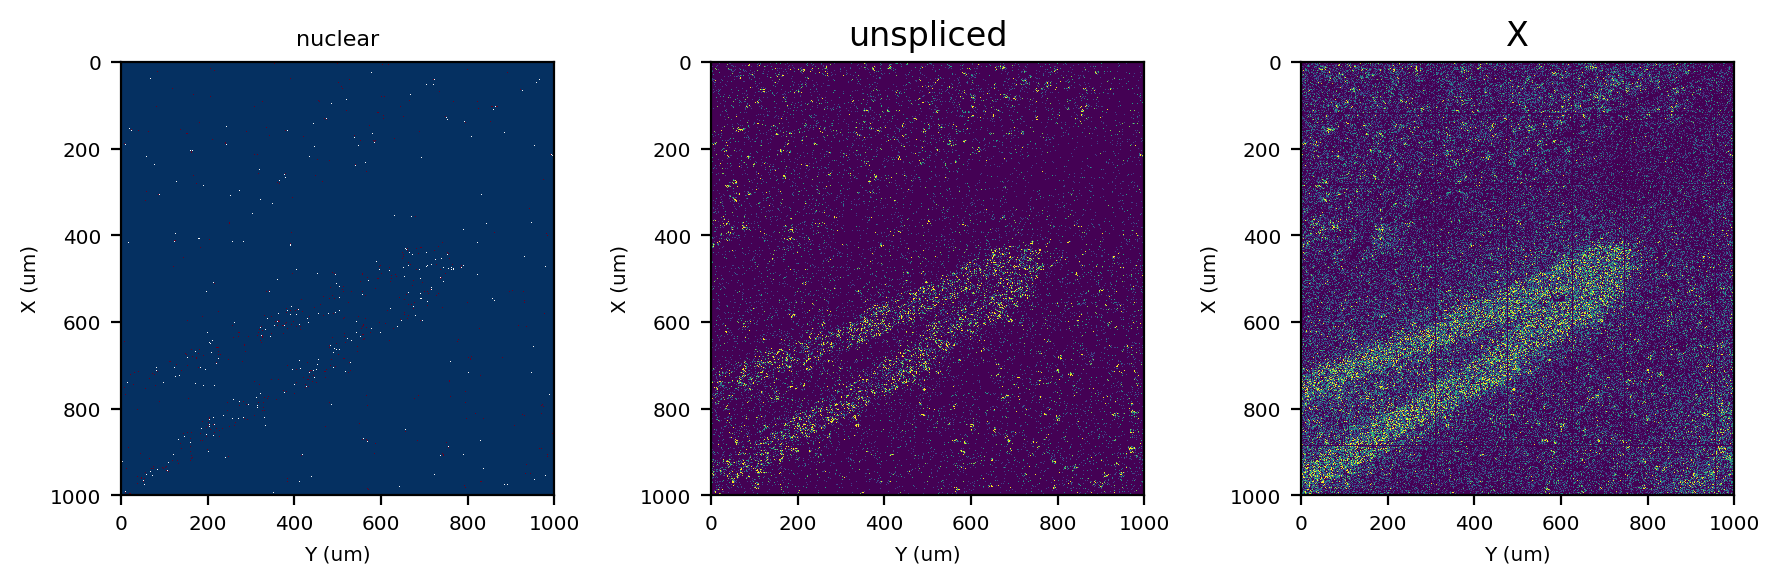

In [3]:
fig, axes = plt.subplots(ncols=3, figsize=(9, 3), tight_layout=True)
st.pl.imshow(adata, 'nuclear', ax=axes[0], vmax=2, save_show_or_return='return')
st.pl.imshow(adata, 'unspliced', ax=axes[1], vmax=5, save_show_or_return='return')
st.pl.imshow(adata, 'X', ax=axes[2], vmax=10)

## Identify nuclei with nuclear localized genes

### Density binning

As we can observe above, there are regions of high and low RNA density. This requires separating the image into several density regions, and then running segmentation on each region separately. Otherwise, the algorithm is likely to be mis-calibrated and be too sensitive in RNA-rich regions and too strict in RNA-sparse regions.

We recommend first starting off with a lenient (a.k.a. split the pixels into many RNA density regions) and then merging regions manually.

|-----> <select> nuclear layer in AnnData Object
|-----> Finding density bins.
|-----> <insert> nuclear_bins to layers in AnnData Object.
|-----> <select> nuclear_bins layer in AnnData Object


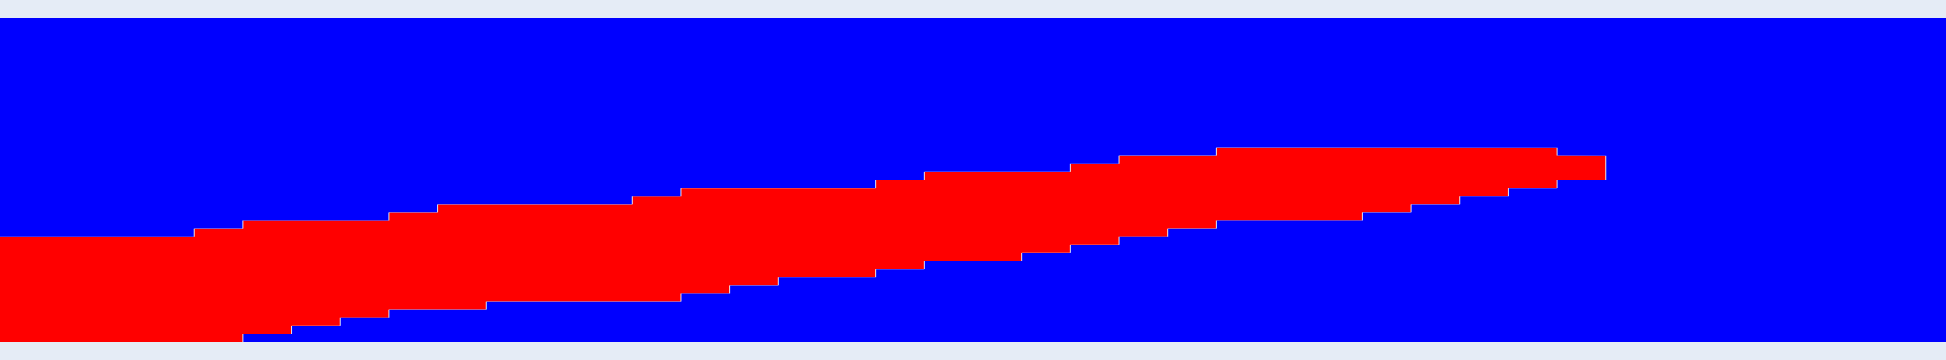

In [49]:
st.cs.segment_densities(adata, 'nuclear', 50, k=3, dk=3, distance_threshold=3, background=False)
st.pl.contours(adata, 'nuclear_bins', scale=0.15)

|-----> <select> nuclear_bins layer in AnnData Object


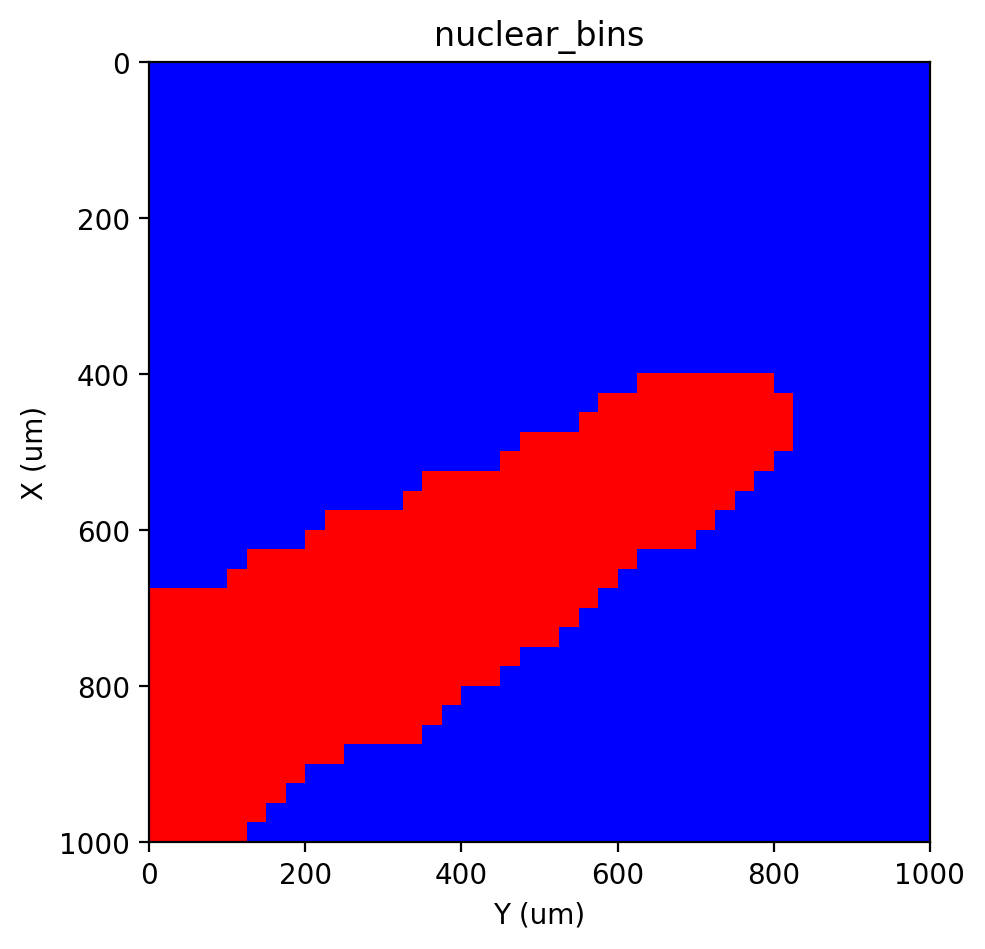

In [50]:
st.pl.imshow(adata, 'nuclear_bins', labels=True)

### Segmentation

<div class="alert alert-info">
Note
    
In this tutorial, we will be using the `VI+BP` method exclusively, but there are other methods available. See [Segmentation approaches](../../technicals/cell_segmentation.md#segmentation-approaches)

</div>

We offer other several options (EM+BP, gOTSU, Moran's I, VI+BP) to get the foreground mask in the following, users could select one of them.

|-----> <select> nuclear layer in AnnData Object
|-----> Scoring pixels with em+bp method.


Running EM:   0%|          | 0/1 [00:00<?, ?it/s]2023-05-26 14:49:46.307842: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/panhailin/miniconda3/envs/spateo/lib/python3.8/site-packages/spaghetti-1.6.5-py3.8.egg/spaghetti/network.py:36: FutureWarning:

The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.



|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


Running EM: 100%|##########| 1/1 [00:12<00:00, 12.82s/it]


|-----> <insert> nuclear_scores to layers in AnnData Object.
|-----> Applying threshold 0.3655256793645607.
threshold: 0.3655256793645607
|-----> <insert> nuclear_mask to layers in AnnData Object.
|-----> <select> nuclear_mask layer in AnnData Object


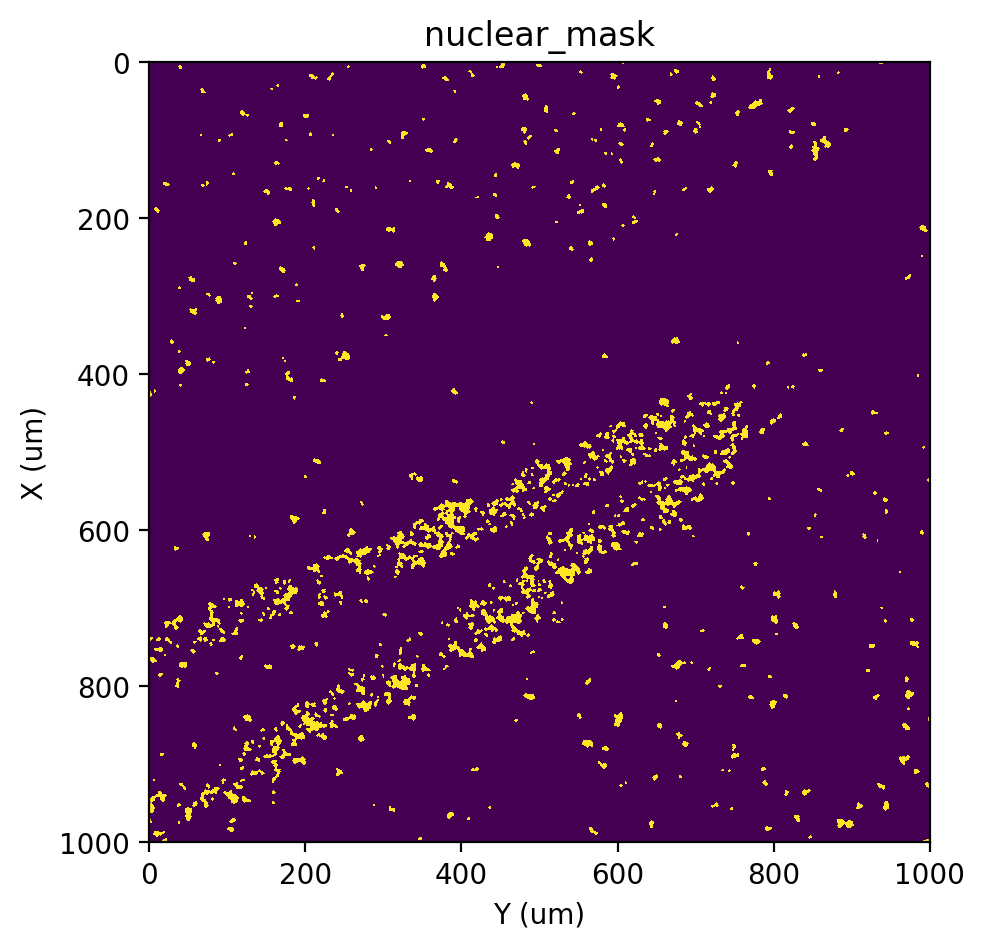

In [19]:
# EM+BP
st.cs.score_and_mask_pixels(
    adata, 'nuclear', k=5, method='EM+BP',
)

st.pl.imshow(adata, 'nuclear_mask')

|-----> <select> nuclear layer in AnnData Object
|-----> Scoring pixels with gauss method.
|-----> <insert> nuclear_scores to layers in AnnData Object.
|-----> Applying threshold 0.068359375.
threshold: 0.068359375
|-----> <insert> nuclear_mask to layers in AnnData Object.
|-----> <select> nuclear_mask layer in AnnData Object


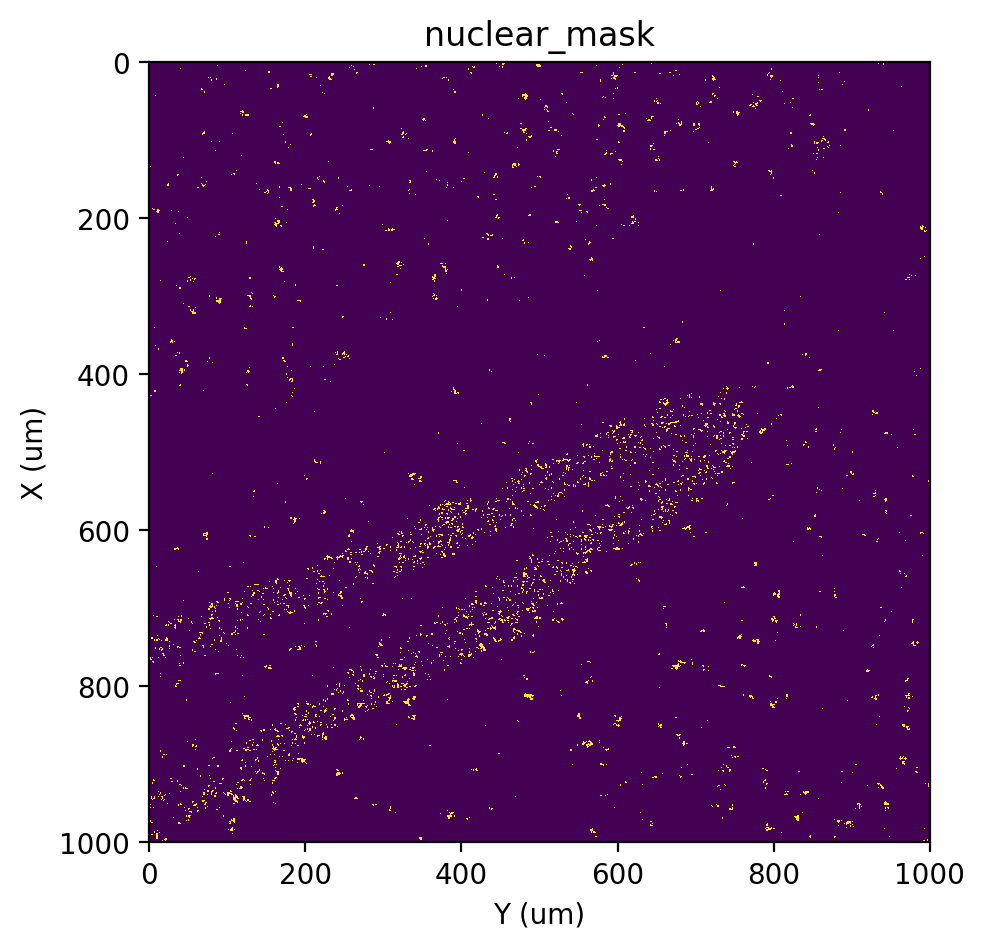

In [16]:
# gOTSU
st.cs.score_and_mask_pixels(
    adata, 'nuclear', k=5, method='gauss',
)

st.pl.imshow(adata, 'nuclear_mask')

|-----> <select> nuclear layer in AnnData Object
|-----> run Moran’s I.
|-----> <insert> nuclear_mask to layers in AnnData Object.
|-----> <select> nuclear_mask layer in AnnData Object


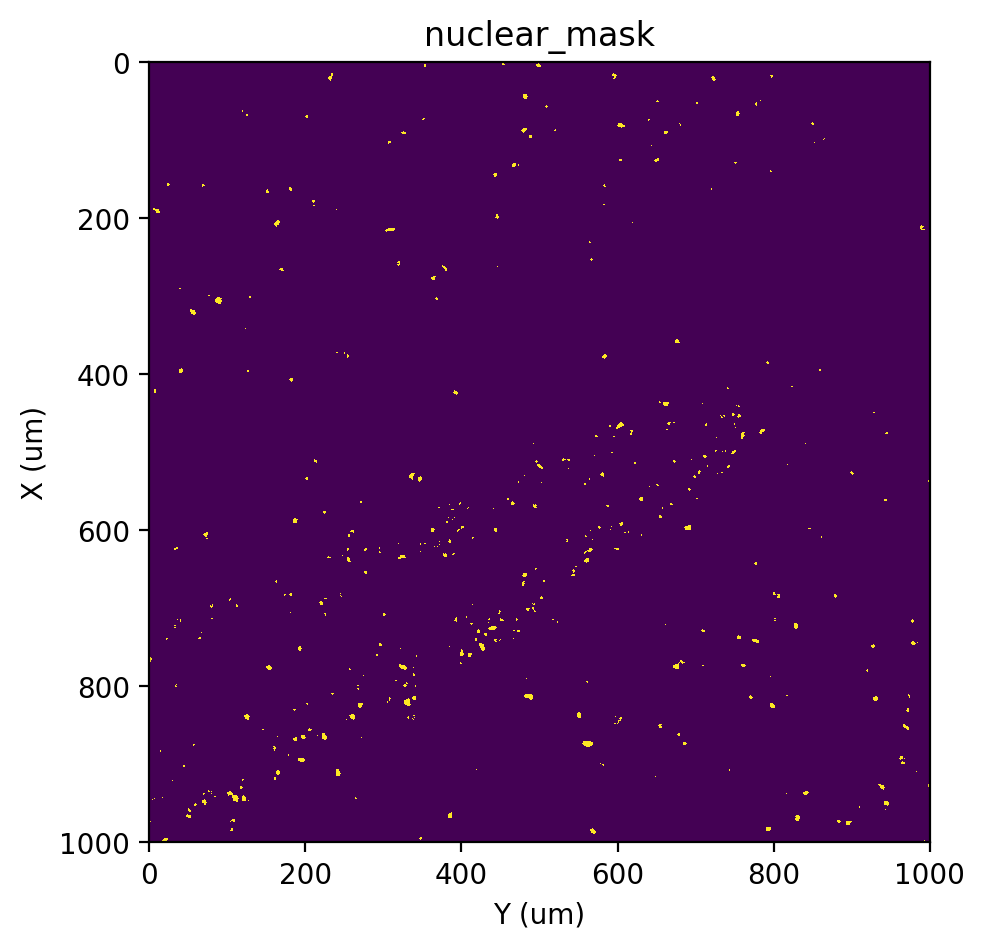

In [57]:
# Moran's I
st.cs.moran.run_moran_and_mask_pixels(adata, 'nuclear', k=21)

st.pl.imshow(adata, 'nuclear_mask')

|-----> <select> nuclear layer in AnnData Object
|-----> Scoring pixels with vi+bp method.


Loss 2.4553e-01: 100%|██████████| 500/500 [00:16<00:00, 30.93it/s]


|-----> <insert> nuclear_scores to layers in AnnData Object.
|-----> Applying threshold 0.4650400256077418.
threshold: 0.4650400256077418
|-----> <insert> nuclear_mask to layers in AnnData Object.
|-----> <select> nuclear_mask layer in AnnData Object


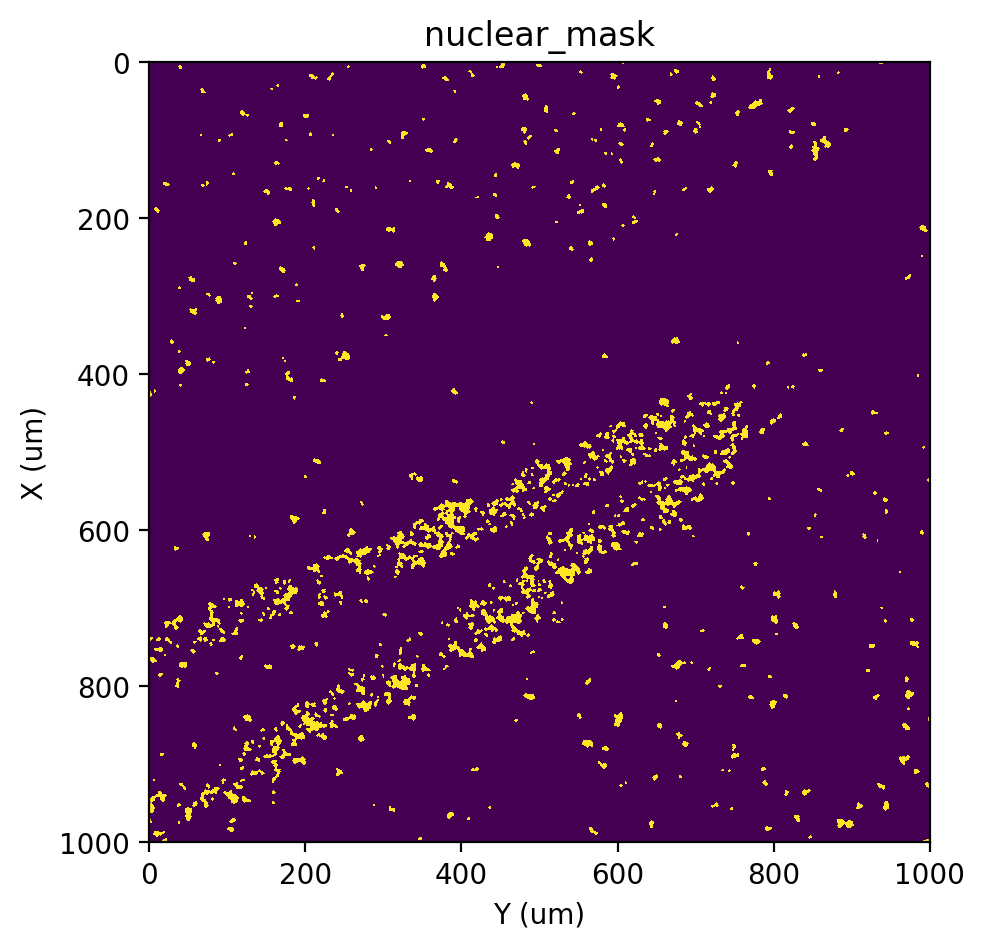

In [18]:
# VI+BP (Variational inference + Belief propagation)
st.cs.score_and_mask_pixels(
    adata, 'nuclear', k=5, method='VI+BP',
    vi_kwargs=dict(downsample=0.1, seed=0, zero_inflated=True)
)

st.pl.imshow(adata, 'nuclear_mask')

Here, we use EM+BP as a emample, so we need to re-run this option to repalce the nuclear_mask generate by previous options.

|-----> <select> nuclear layer in AnnData Object
|-----> Scoring pixels with em+bp method.


Running EM: 100%|##########| 1/1 [00:02<00:00,  2.91s/it]


|-----> <insert> nuclear_scores to layers in AnnData Object.
|-----> Applying threshold 0.4902488613509294.
threshold: 0.4902488613509294
|-----> <insert> nuclear_mask to layers in AnnData Object.
|-----> <select> nuclear_mask layer in AnnData Object


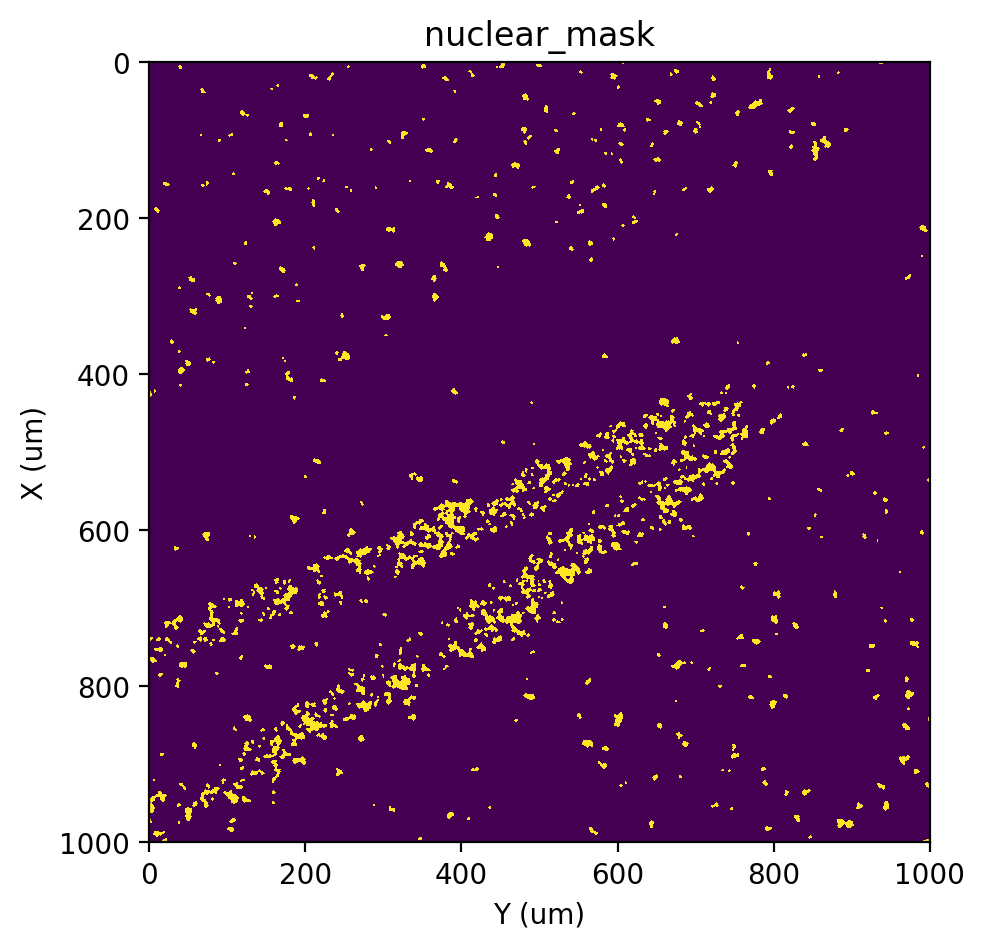

In [20]:
# EM+BP
st.cs.score_and_mask_pixels(
    adata, 'nuclear', k=5, method='EM+BP',
)

st.pl.imshow(adata, 'nuclear_mask')

### Labeling

|-----> <select> nuclear_mask layer in AnnData Object
|-----> Finding peaks with minimum distance 7.
|-----> <insert> nuclear_distances to layers in AnnData Object.
|-----> <insert> nuclear_markers to layers in AnnData Object.
|-----> <select> nuclear_distances layer in AnnData Object
|-----> <select> nuclear_mask layer in AnnData Object
|-----> <select> nuclear_markers layer in AnnData Object
|-----> Running Watershed.
|-----> <insert> nuclear_labels to layers in AnnData Object.
|-----> <select> nuclear_labels layer in AnnData Object


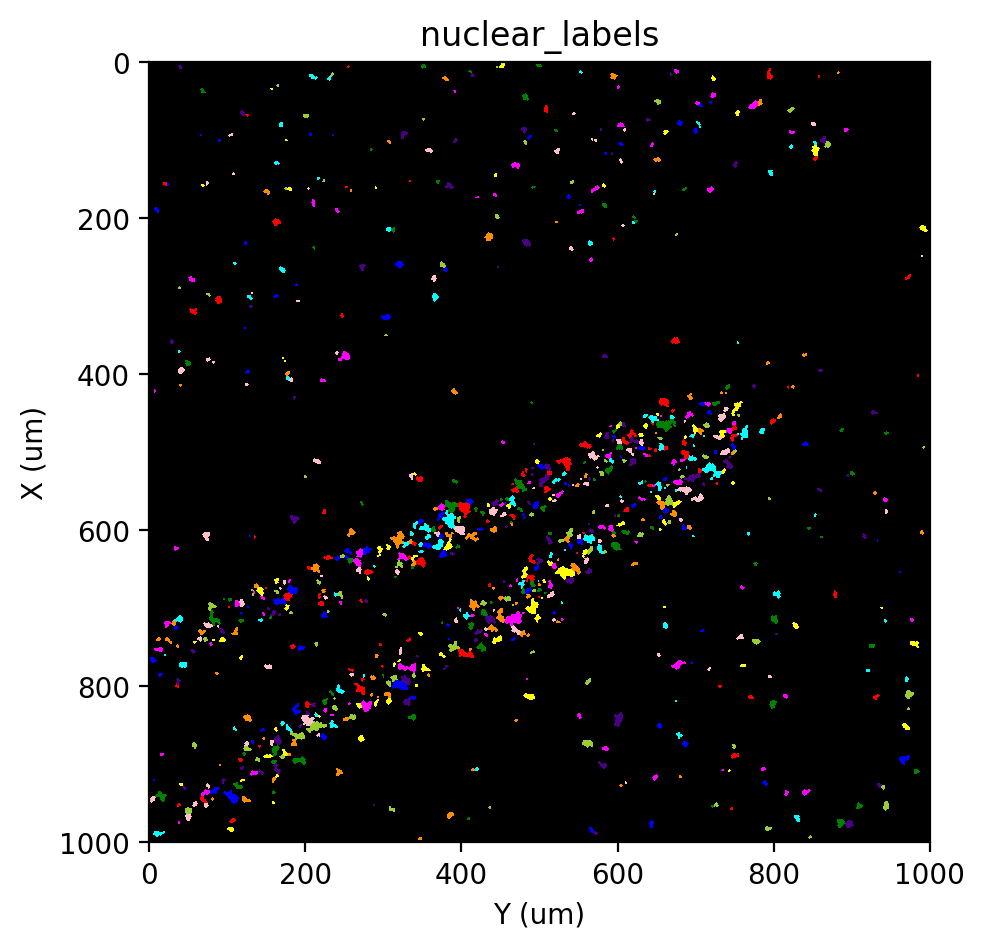

In [21]:
st.cs.find_peaks_from_mask(adata, 'nuclear', 7)
st.cs.watershed(
    adata, 'nuclear_distances', 1,
    mask_layer='nuclear_mask',
    markers_layer='nuclear_markers',
    out_layer='nuclear_labels'
)

st.pl.imshow(adata, 'nuclear_labels', labels=True)

## Identify additional nuclei with unspliced RNA

### Density binnning

|-----> <select> unspliced layer in AnnData Object
|-----> Finding density bins.
|-----> <insert> unspliced_bins to layers in AnnData Object.
|-----> <select> unspliced_bins layer in AnnData Object


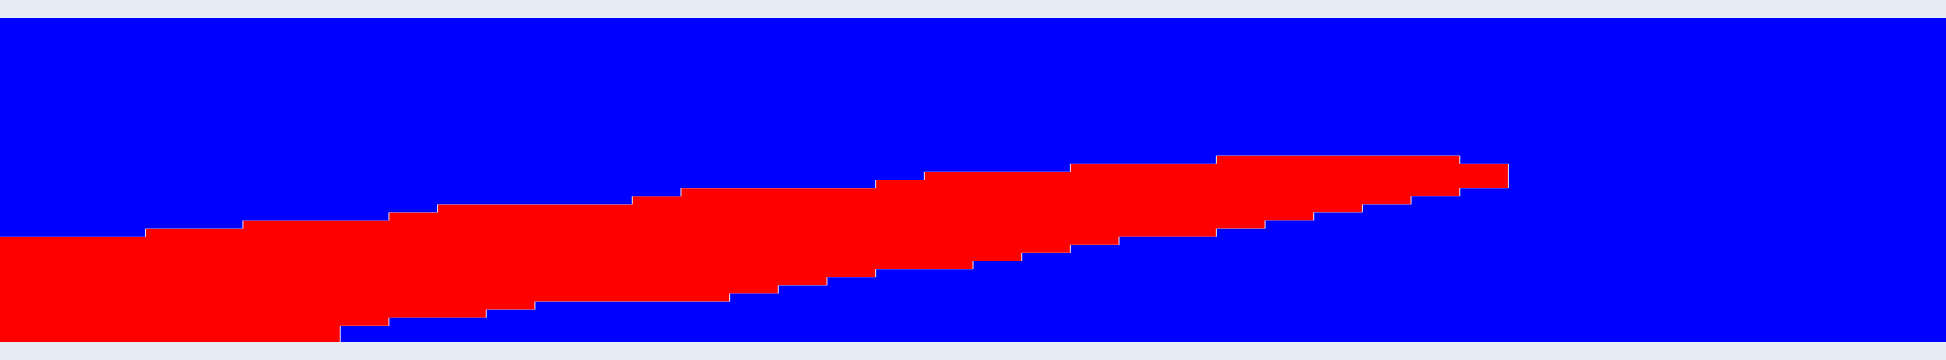

In [26]:
st.cs.segment_densities(adata, 'unspliced', 50, k=3, dk=3, distance_threshold=3, background=False)
st.pl.contours(adata, 'unspliced_bins', scale=0.15)

|-----> <select> unspliced_bins layer in AnnData Object


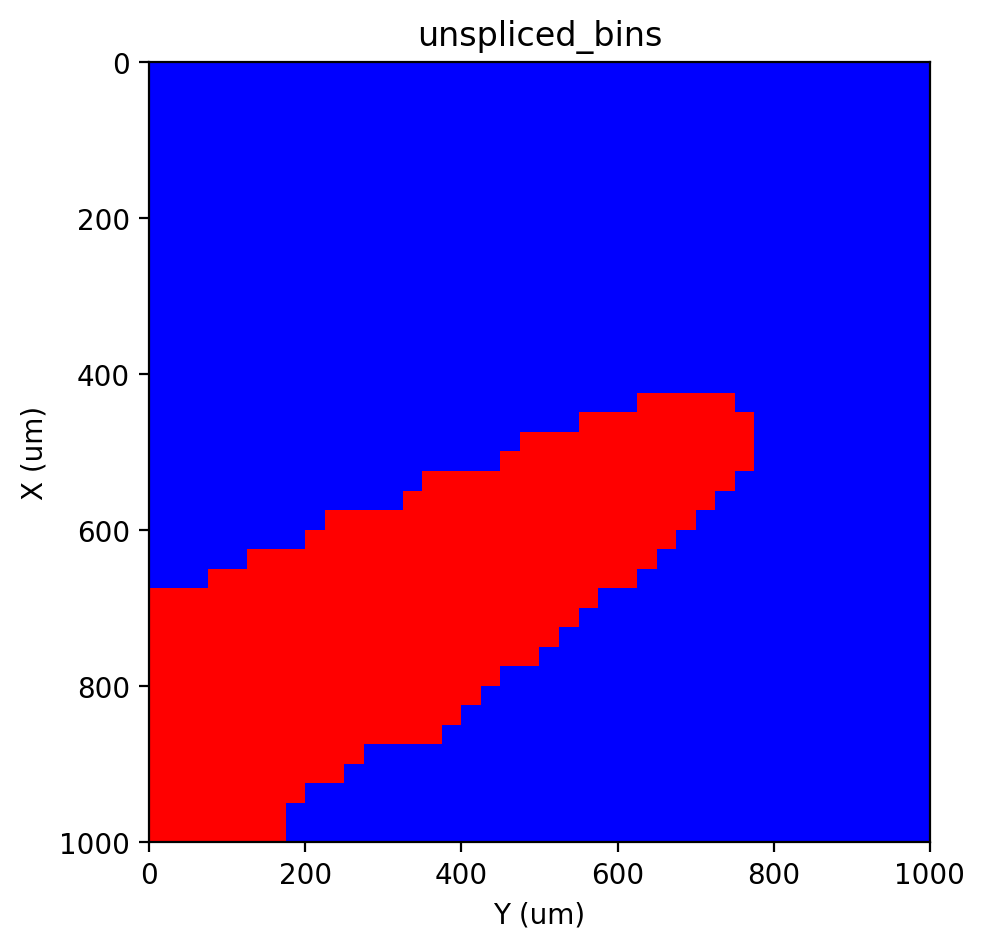

In [27]:
st.pl.imshow(adata, 'unspliced_bins', labels=True)

### Segmentation

Then, as we did previously for the nuclear gene counts, identify nuclei using unspliced RNA. Note that the function will automatically detect the RNA density bins and adjust the algorithm accordingly. Also, note that we provide the `certain_layer` argument to `st.pp.segmentation.score_and_mask_pixels` and the `seed_layer` argument to `st.pp.segmentation.label_connected_components` to indicate the nuclei labels obtained from nuclear localized genes. Internally, these labels are used to further aid the identification of real nuclei.

Again, users could select either one option to create the foreground mask as in previous "Segmentaion" section in "Identify nuclei with nuclear localized genes".

|-----> <select> unspliced layer in AnnData Object
|-----> <select> nuclear_labels layer in AnnData Object
|-----> <select> unspliced_bins layer in AnnData Object
|-----> Scoring pixels with em+bp method.
|-----? `vi_kwargs` will be ignored.


Running EM: 100%|##########| 2/2 [00:03<00:00,  1.63s/it]


|-----> <insert> unspliced_scores to layers in AnnData Object.
|-----> Applying threshold 0.4712305965076491.
threshold: 0.4712305965076491
|-----> <insert> unspliced_mask to layers in AnnData Object.
|-----> <select> unspliced_mask layer in AnnData Object


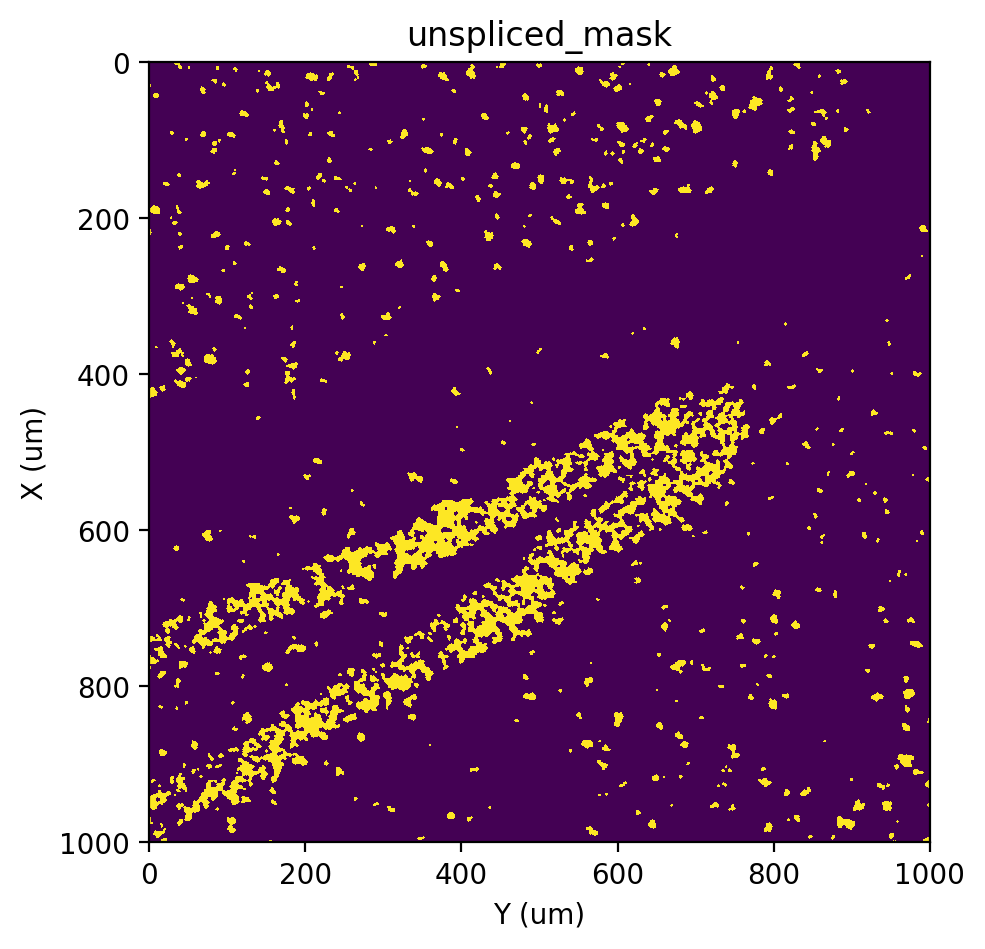

In [28]:
st.cs.score_and_mask_pixels(
    adata, 'unspliced', k=5, method='EM+BP',
    vi_kwargs=dict(downsample=0.1, seed=0),
    certain_layer='nuclear_labels'
)

st.pl.imshow(adata, 'unspliced_mask')

### Labeling

Unlike previously when we used nuclear localized genes, here we know some initial labels that we would like to retain (and in some cases, make larger to fill the above mask). Additionally, using unspliced labels seems to over-saturate some RNA-dense areas, so much so that it is difficult to tell the boundaries of cells in these areas. Therefore, instead of using a Watershed approach, which would attempt to "fill up" the entire mask, we will use `st.cs.label_connected_components` to limit the maximum area each label can be assigned. 

Note that we provide the `seed_label` argument to be the labels we obtained previously using nuclear localized genes.

|-----> <select> unspliced_mask layer in AnnData Object
|-----> <select> nuclear_labels layer in AnnData Object


Expanding: 100%|██████████| 8/8 [00:01<00:00,  4.94it/s]


|-----> <insert> unspliced_labels to layers in AnnData Object.
|-----> <select> unspliced_labels layer in AnnData Object


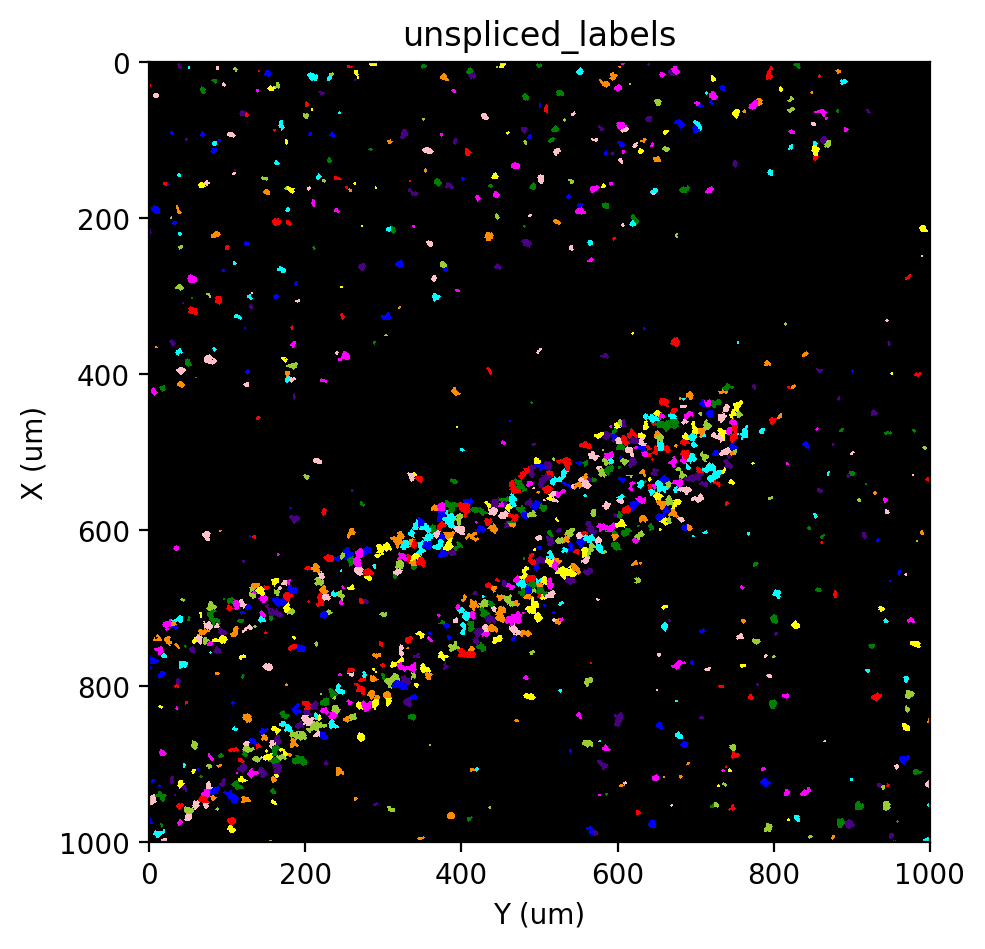

In [29]:
st.cs.label_connected_components(adata, 'unspliced', seed_layer='nuclear_labels')

st.pl.imshow(adata, 'unspliced_labels', labels=True)

## [Optional] Identify cytoplasm

Though it is possible to use the above labels directly as each nuclei, we would ideally like to expand these labels to cover the cytoplasm.

### Density binning

|-----> <select> X layer in AnnData Object
|-----> Finding density bins.
|-----> <insert> X_bins to layers in AnnData Object.
|-----> <select> X_bins layer in AnnData Object


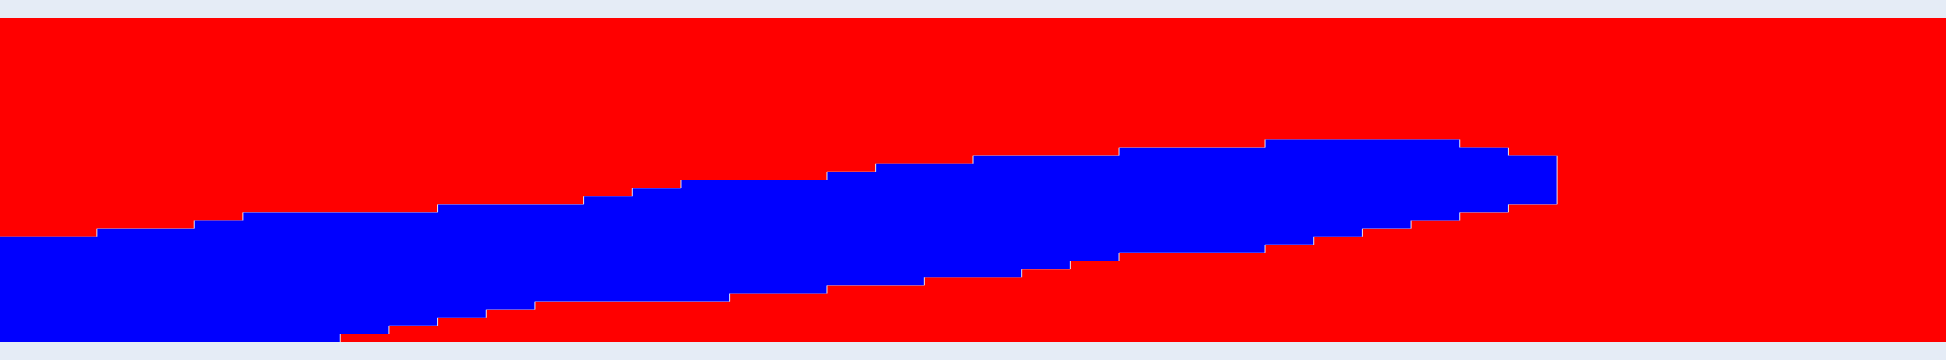

In [30]:
st.cs.segment_densities(adata, 'X', 50, k=3, distance_threshold=3, dk=5, background=False)
st.pl.contours(adata, 'X_bins', scale=0.15)

|-----> <select> X_bins layer in AnnData Object


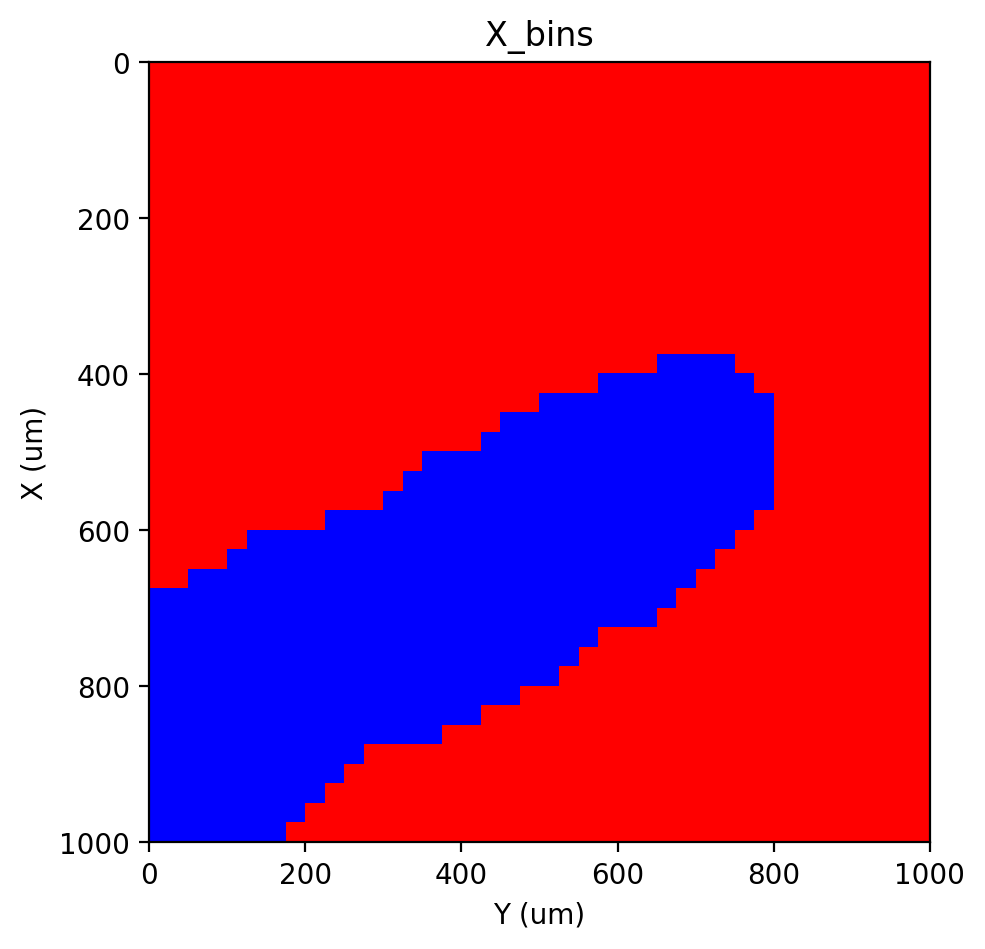

In [31]:
st.pl.imshow(adata, 'X_bins', labels=True)

### Segmentation

|-----> <select> X layer in AnnData Object
|-----> <select> unspliced_labels layer in AnnData Object
|-----> <select> X_bins layer in AnnData Object
|-----> Scoring pixels with em+bp method.
|-----? `vi_kwargs` will be ignored.


Running EM: 100%|##########| 2/2 [00:03<00:00,  1.77s/it]


|-----> <insert> X_scores to layers in AnnData Object.
|-----> Applying threshold 0.5214540748536795.
threshold: 0.5214540748536795
|-----> <insert> X_mask to layers in AnnData Object.
|-----> <select> X_mask layer in AnnData Object


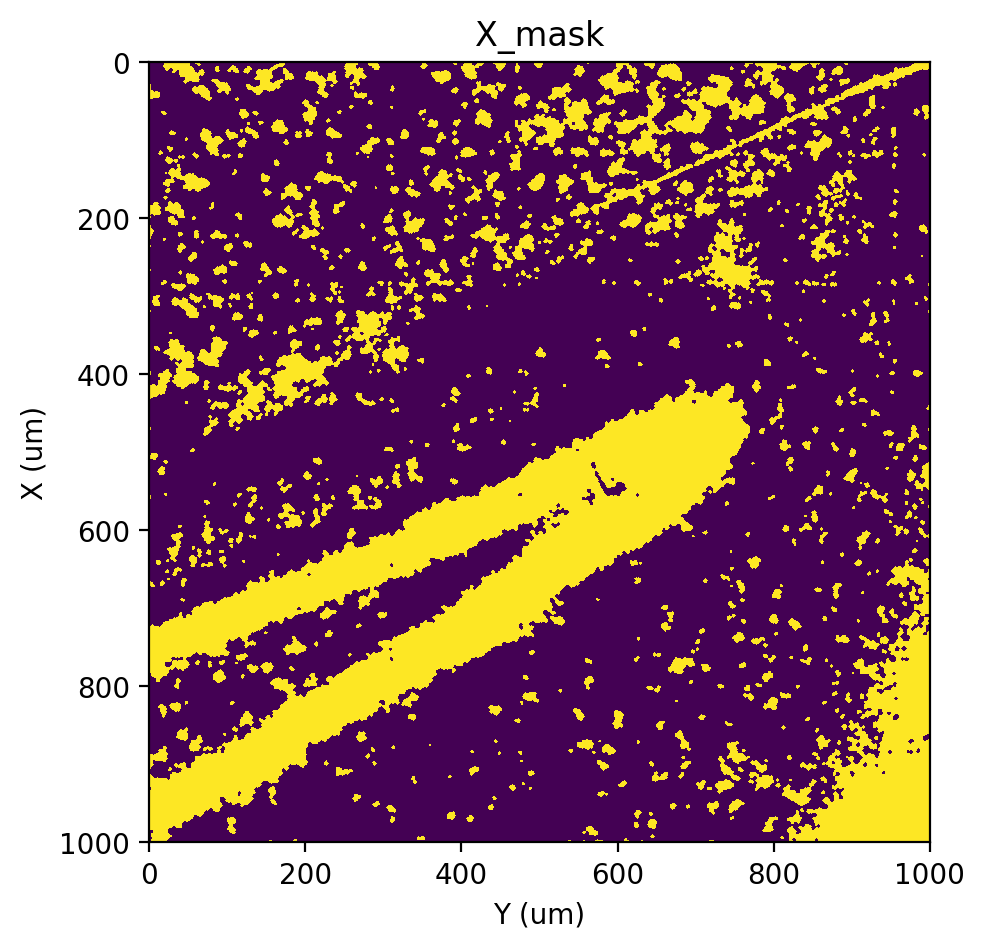

In [32]:
st.cs.score_and_mask_pixels(
    adata, 'X', k=7, method='EM+BP',
    vi_kwargs=dict(downsample=0.1, seed=0),
    certain_layer='unspliced_labels'
)

st.pl.imshow(adata, 'X_mask')

### Labeling

|-----> <select> X_mask layer in AnnData Object
|-----> <select> unspliced_labels layer in AnnData Object


Eroding: 32it [00:00, 417.22it/s]
Expanding: 100%|██████████| 8/8 [00:03<00:00,  2.45it/s]


|-----> <insert> X_labels to layers in AnnData Object.
|-----> <select> X_labels layer in AnnData Object


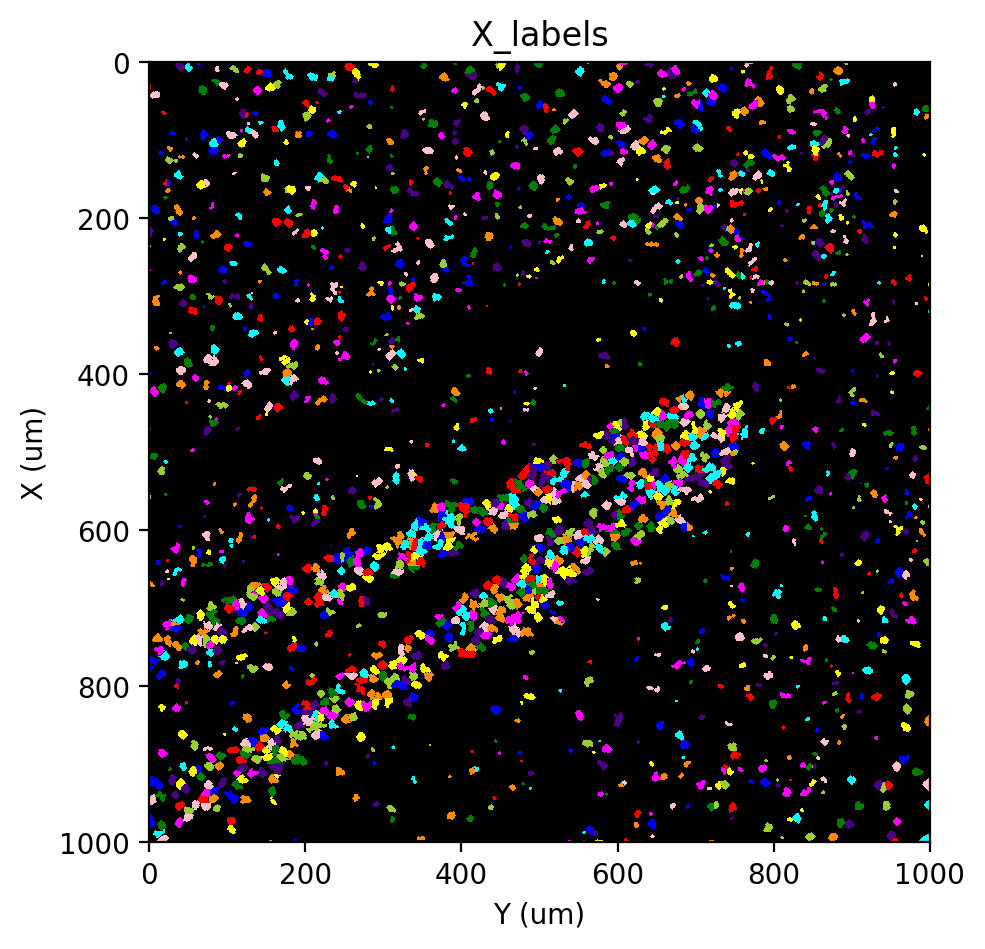

In [33]:
st.cs.label_connected_components(adata, 'X', seed_layer='unspliced_labels')

st.pl.imshow(adata, 'X_labels', labels=True)

## Getting a cell x gene matrix

Finally, we will use our segmentation results to obtain the desired cell-by-gene counts matrix.

But first, we will expand all the cell labels by some amount to mitigate the effects of RNA diffusion. The distance that should be expanded will depend on the level of RNA diffusion in the data.

|-----> <select> X_labels layer in AnnData Object
|-----> Expanding labels.


Expanding: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

|-----> <insert> X_labels_expanded to layers in AnnData Object.
|-----> <select> X_labels_expanded layer in AnnData Object


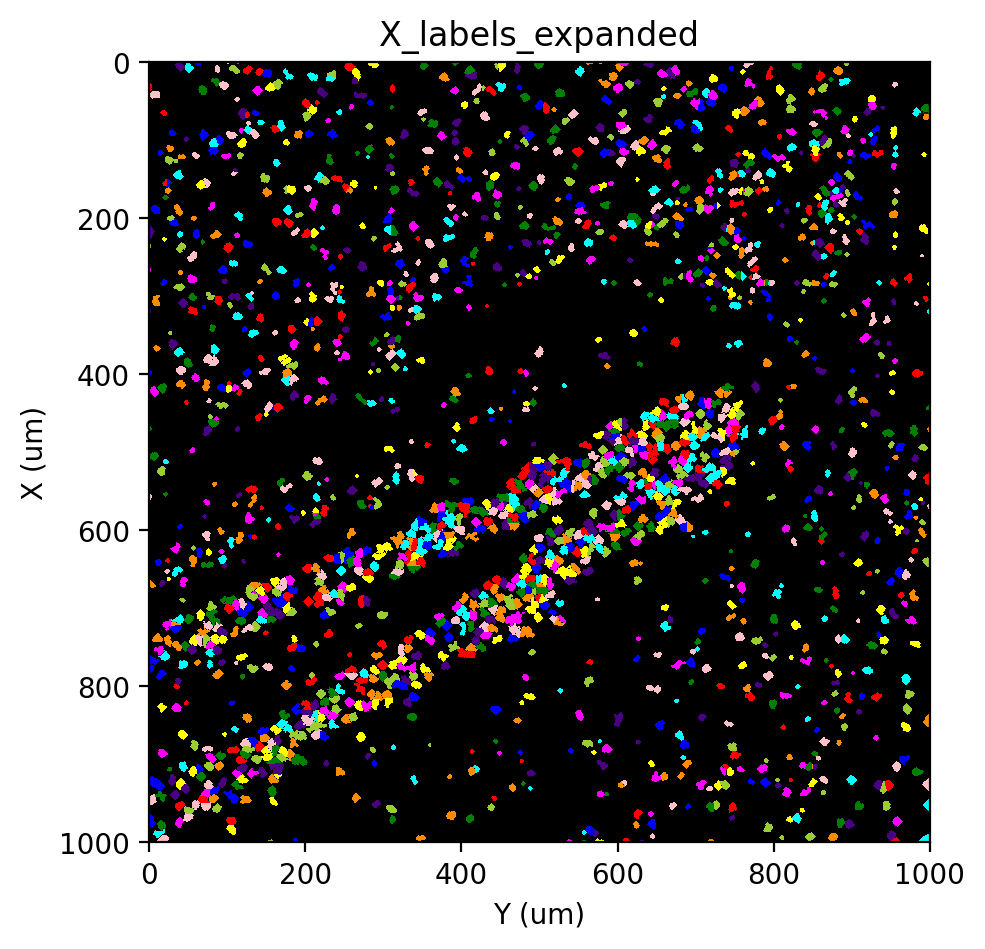

In [34]:
st.cs.expand_labels(
    adata, 'X_labels', distance=2, out_layer='X_labels_expanded'
)

st.pl.imshow(adata, 'X_labels_expanded', labels=True)

In [35]:
cell_adata = st.io.read_bgi(
    'SS200000135TL_D1_all_bin1.txt.gz',
    segmentation_adata=adata,
    labels_layer='X_labels_expanded',
)
cell_adata

|-----> <select> X_labels_expanded layer in AnnData Object
|-----> Using labels provided with `segmentation_adata` and `labels_layer` arguments.
|-----> Constructing count matrices.
|-----> <insert> __type to uns in AnnData Object.
|-----> <insert> pp to uns in AnnData Object.
|-----> <insert> spatial to uns in AnnData Object.


AnnData object with n_obs × n_vars = 1847 × 19815
    obs: 'area'
    uns: '__type', 'pp', 'spatial'
    obsm: 'spatial', 'contour', 'bbox'
    layers: 'spliced', 'unspliced'